# Customer Churn Prediction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
pd.set_option("display.max_columns", None)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#### Data Preparation based on EDA

In [2]:
def datapreparation(filepath):
    
    df = pd.read_csv(filepath)
    df.drop(["customerID"], inplace = True, axis = 1)
    
    df.TotalCharges = df.TotalCharges.replace(" ",0)
    #df.TotalCharges.fillna(0, inplace = True)
    df.TotalCharges = df.TotalCharges.astype(float)
    
    cols1 = ['Partner', 'Dependents', 'PaperlessBilling', 'Churn', 'PhoneService']
    for col in cols1:
        df[col] = df[col].apply(lambda x: 0 if x == "No" else 1)
   
    df.gender = df.gender.apply(lambda x: 0 if x == "Male" else 1)
    df.MultipleLines = df.MultipleLines.map({'No phone service': 0, 'No': 0, 'Yes': 1})
    
    cols2 = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
    for col in cols2:
        df[col] = df[col].map({'No internet service': 0, 'No': 0, 'Yes': 1})
    
    df = pd.get_dummies(df, columns=['InternetService', 'Contract', 'PaymentMethod'], drop_first=True)
     
    return df

In [3]:
df = datapreparation(filepath = "Telco-Customer-Churn.csv")
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,0,1,0,1,0,0,0,1,0,0,0,0,1,29.85,29.85,0,0,0,0,0,0,1,0
1,0,0,0,0,34,1,0,1,0,1,0,0,0,0,56.95,1889.50,0,0,0,1,0,0,0,1
2,0,0,0,0,2,1,0,1,1,0,0,0,0,1,53.85,108.15,1,0,0,0,0,0,0,1
3,0,0,0,0,45,0,0,1,0,1,1,0,0,0,42.30,1840.75,0,0,0,1,0,0,0,0
4,1,0,0,0,2,1,0,0,0,0,0,0,0,1,70.70,151.65,1,1,0,0,0,0,1,0


In [4]:
df.isnull().any().any()

False

In [5]:
df.shape

(7043, 24)

## Model Building

I am going to build and tune the random forest model, as I am interested in the important features that impact the probability of churn. 

In [12]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix , accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn import ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_roc_curve
from sklearn.ensemble import RandomForestClassifier

In [7]:
train, test = train_test_split(df, test_size = 0.2, random_state= 42, stratify = df.Churn)

In [8]:
x = df.columns[df.columns!="Churn"]
y = "Churn"
X_train = train[x]
y_train = train[y]
X_test = test[x]
y_test = test[y]

In [9]:
#function for model fitting
from sklearn.metrics import confusion_matrix
def churn_prediction(model, X_train, y_train, X_test, y_test, cols, cf = 'coefficients'):
    model.fit(X_train,y_train)
    predictions = model.predict(X_test)
    probabilities = model.predict_proba(X_test)[:,1]
    
    #coeffs
    if cf == "coefficients":
        coefficients = pd.DataFrame(model.coef_.ravel())
    elif cf == "features":
        coefficients = pd.DataFrame(model.feature_importances_)
        
    column_df = pd.DataFrame(cols)
    coef_summary = (pd.merge(column_df, coefficients,left_index= True,
                              right_index= True, how = "left"))
    coef_summary.columns = ["features", "coefficients"]
    coef_summary = coef_summary.sort_values(by = "coefficients",ascending = False)
    
    print (model)
    print ("\n Classification report : \n",classification_report(y_test,predictions))
    print ("Accuracy   Score : ",accuracy_score(y_test,predictions))
    print ("f1 Score : ",f1_score(y_test, predictions))
    
    #confusion matrix
    conf_matrix = confusion_matrix(y_test,predictions)
    print("confusion matrix : \n", conf_matrix)
    plt.figure(figsize=(12,12))
    plt.subplot(221)
    sns.heatmap(conf_matrix, fmt = "d",annot=True, cmap='Blues')
    plt.title('Confuion Matrix')
    plt.ylabel('True Values')
    plt.xlabel('Predicted Values')
    
    #roc_auc_score
    model_roc_auc = roc_auc_score(y_test,probabilities) 
    print ("Area under curve (AUC) : ",model_roc_auc,"\n")
    plot_roc_curve(model, X_test, y_test)
    plt.show()
#     fpr,tpr,thresholds = roc_curve(y_test,probabilities)
#     plt.subplot(222)
#     plt.plot(fpr, tpr, color='darkorange', lw=1, label = "Auc : %.3f" %model_roc_auc)
#     plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.05])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('Receiver operating characteristic')
#     plt.legend(loc="lower right")
    
    plt.subplot(212)
    sns.barplot(x = coef_summary["features"] ,y = coef_summary["coefficients"])
    plt.title('Feature Importances')
    plt.xticks(rotation="vertical")
    
    plt.show()

LogisticRegression()

 Classification report : 
               precision    recall  f1-score   support

           0       0.84      0.89      0.87      1035
           1       0.64      0.54      0.59       374

    accuracy                           0.80      1409
   macro avg       0.74      0.72      0.73      1409
weighted avg       0.79      0.80      0.79      1409

Accuracy   Score :  0.7984386089425124
f1 Score :  0.5860058309037901
confusion matrix : 
 [[924 111]
 [173 201]]
Area under curve (AUC) :  0.8421039034849775 



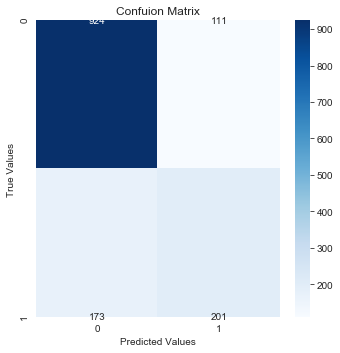

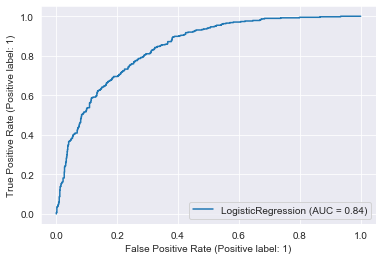

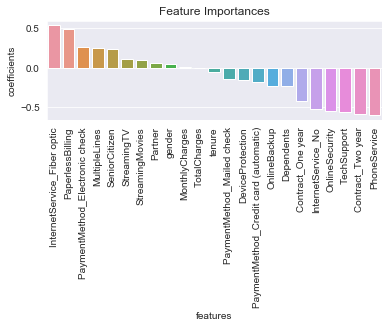

In [10]:
lr = LogisticRegression()
churn_prediction(lr, X_train, y_train, X_test, y_test, x)

### Hyperparameters Tuning

#### Grid 1: Selecting features and estimators

In [14]:
param_grid1 = {'max_features':['auto', 'sqrt', 'log2', None],
          'n_estimators':[500, 700, 900, 1100, 1300]
         }

rf_model = RandomForestClassifier()
grid1 = GridSearchCV(estimator=rf_model, param_grid=param_grid1, n_jobs=-1, cv=3, verbose=1, scoring = 'f1')
grid1.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_features': ['auto', 'sqrt', 'log2', None],
                         'n_estimators': [500, 700, 900, 1100, 1300]},
             scoring='f1', verbose=1)

In [15]:
grid1.best_estimator_

RandomForestClassifier(max_features='log2', n_estimators=1100)

In [16]:
grid1.best_score_

0.5612834812096338

In [17]:
dt = pd.DataFrame(grid1.cv_results_)
#print(dt)
dt.param_max_features = dt.param_max_features.astype(str)
dt.param_n_estimators = dt.param_n_estimators.astype(str)

table = pd.pivot_table(dt, values='mean_test_score', index='param_n_estimators', 
                       columns='param_max_features')
print(table)  
#sns.heatmap(table)

param_max_features      None      auto      log2      sqrt
param_n_estimators                                        
1100                0.550730  0.557725  0.561283  0.557267
1300                0.552403  0.558085  0.557476  0.558183
500                 0.551407  0.555956  0.558866  0.559405
700                 0.552497  0.559382  0.561208  0.560582
900                 0.554744  0.553949  0.559605  0.555675


#### Grid 2: Selecting max depth and split criterion

In [18]:
param_grid2 = {'max_features':['auto','log2'],
          'n_estimators':[900,  1000, 1100, 1200],
           'criterion': ['entropy', 'gini'],    
          'max_depth': [7, 9, 11, 13, 15, None],
         }

rf_model = RandomForestClassifier()
grid2 = GridSearchCV(estimator=rf_model, param_grid=param_grid2, n_jobs=-1, cv=3, verbose=1, scoring = 'f1')
grid2.fit(X_train, y_train)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [7, 9, 11, 13, 15, None],
                         'max_features': ['auto', 'log2'],
                         'n_estimators': [900, 1000, 1100, 1200]},
             scoring='f1', verbose=1)

In [19]:
grid2.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=9, max_features='log2',
                       n_estimators=1100)

In [20]:
grid2.best_score_

0.5757384108188118

In [21]:
dt = pd.DataFrame(grid2.cv_results_)

table = pd.pivot_table(dt, values='mean_test_score', index='param_max_depth', 
                       columns='param_criterion')
print(table)     
#sns.heatmap(table)

param_criterion   entropy      gini
param_max_depth                    
7                0.559749  0.560754
9                0.572807  0.571523
11               0.572732  0.569213
13               0.567994  0.567453
15               0.564852  0.564457


#### Grid 3: Selecting minimum samples leaf and samples split

In [22]:
param_grid3 = {'max_features':['auto', 'log2'],
          'n_estimators':[1100],
           'criterion': ['entropy'],    
          'max_depth': [9,11],
          'min_samples_leaf': [1, 3, 5, 7],
          'min_samples_split': [2, 4, 6, 8]
         }

rf_model = RandomForestClassifier()
grid3 = GridSearchCV(estimator=rf_model, param_grid=param_grid3, n_jobs=-1, cv=3, verbose=1, scoring = 'f1')
grid3.fit(X_train, y_train)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['entropy'], 'max_depth': [9, 11],
                         'max_features': ['auto', 'log2'],
                         'min_samples_leaf': [1, 3, 5, 7],
                         'min_samples_split': [2, 4, 6, 8],
                         'n_estimators': [1100]},
             scoring='f1', verbose=1)

In [23]:
grid3.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=11, min_samples_leaf=5,
                       min_samples_split=6, n_estimators=1100)

In [24]:
grid3.best_score_

0.5805174412356856

In [25]:
dt = pd.DataFrame(grid3.cv_results_)

table = pd.pivot_table(dt, values='mean_test_score', index='param_min_samples_leaf', 
                       columns='param_min_samples_split')
     
print(table)
#sns.heatmap(table)

param_min_samples_split         2         4         6         8
param_min_samples_leaf                                         
1                        0.572249  0.571963  0.572966  0.573361
3                        0.572957  0.573767  0.572862  0.574925
5                        0.572643  0.574786  0.574583  0.572260
7                        0.571894  0.570978  0.572598  0.572652


#### Grid 4: Selecting class weight

In [26]:
param_grid4 = {'class_weight':[{0:1, 1:1}, {0:1, 1:2}, {0:1, 1:3}],
            'max_features':['auto','log2'],
          'n_estimators':[1100],
           'criterion': ['entropy'],    
          'max_depth': [11],
          'min_samples_leaf': [5],
          'min_samples_split': [6,8]
         }

rf_model = RandomForestClassifier()
grid4 = GridSearchCV(estimator=rf_model, param_grid=param_grid4, n_jobs=-1, cv=3, verbose=1, scoring = 'f1')
grid4.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2},
                                          {0: 1, 1: 3}],
                         'criterion': ['entropy'], 'max_depth': [11],
                         'max_features': ['auto', 'log2'],
                         'min_samples_leaf': [5], 'min_samples_split': [6, 8],
                         'n_estimators': [1100]},
             scoring='f1', verbose=1)

In [27]:
grid4.best_estimator_

RandomForestClassifier(class_weight={0: 1, 1: 3}, criterion='entropy',
                       max_depth=11, min_samples_leaf=5, min_samples_split=8,
                       n_estimators=1100)

In [28]:
grid4.best_score_

0.6357232702569248

In [29]:
dt = pd.DataFrame(grid4.cv_results_)
dt.param_class_weight = dt.param_class_weight.astype(str)
table = pd.pivot_table(dt, values='mean_test_score', index='param_class_weight')
print(table)     
#sns.heatmap(table)

                    mean_test_score
param_class_weight                 
{0: 1, 1: 1}               0.574519
{0: 1, 1: 2}               0.630054
{0: 1, 1: 3}               0.635164


### Final Model

In [31]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight={0: 1, 1: 3},
                       criterion='entropy', max_depth=11, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0,# min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=1100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

RandomForestClassifier(class_weight={0: 1, 1: 3}, criterion='entropy',
                       max_depth=11, max_features='log2', min_samples_leaf=5,
                       min_samples_split=8, n_estimators=1100)

 Classification report : 
               precision    recall  f1-score   support

           0       0.90      0.76      0.82      1035
           1       0.54      0.78      0.63       374

    accuracy                           0.76      1409
   macro avg       0.72      0.77      0.73      1409
weighted avg       0.81      0.76      0.77      1409

Accuracy   Score :  0.7615330021291696
f1 Score :  0.6331877729257641
confusion matrix : 
 [[783 252]
 [ 84 290]]
Area under curve (AUC) :  0.8453047094990829 



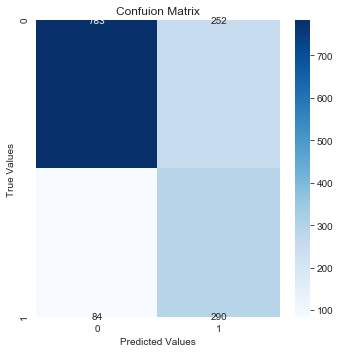

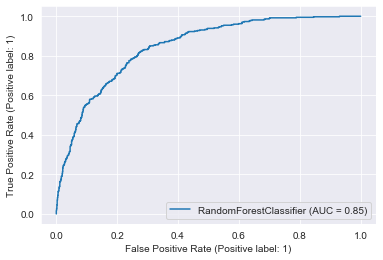

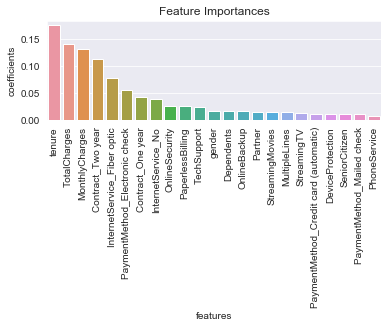

In [32]:
churn_prediction(model, X_train, y_train, X_test, y_test, x,"features")

Checking the model's performance on train data itself

In [33]:
train_scores = cross_val_score(model, X_train, y_train, cv = 5, scoring='f1')
train_scores

array([0.64825581, 0.6568915 , 0.63853727, 0.64285714, 0.60244233])

In [34]:
np.mean(train_scores)

0.6377968115292171

As we can see that the performance of the model on test data is same as training data. So, we can conclude that there is no overfitting and underfitting.

#### Saving model

In [35]:
import pickle
pickle.dump(model, open('model.pkl','wb'))

## Model Explaination

In [36]:
import eli5
from eli5.sklearn import PermutationImportance

from pdpbox import pdp, info_plots

### Permutation Importance

In [38]:
perm = PermutationImportance(model, random_state = 42, scoring = "f1").fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.0490 ± 0.0177,InternetService_Fiber optic
0.0479 ± 0.0147,tenure
0.0324 ± 0.0092,Contract_Two year
0.0254 ± 0.0151,TotalCharges
0.0091 ± 0.0093,Contract_One year
0.0082 ± 0.0007,PhoneService
0.0069 ± 0.0083,TechSupport
0.0055 ± 0.0095,InternetService_No
0.0046 ± 0.0050,OnlineBackup
0.0041 ± 0.0050,PaymentMethod_Mailed check


### Visualizing feature affection using Partial Plots 

#### Tenure

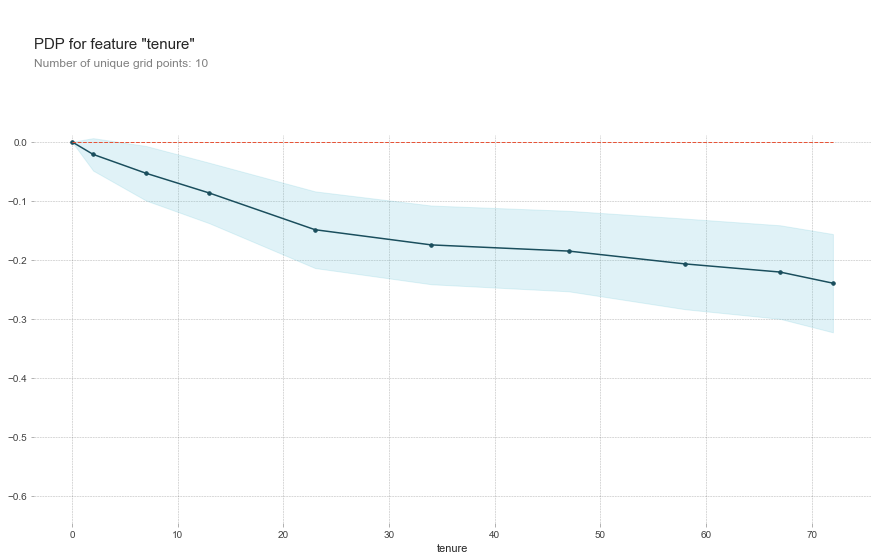

In [39]:
pdp_p = pdp.pdp_isolate(model=model, dataset=X_test, model_features=X_test.columns.values, 
                        feature='tenure')
pdp.pdp_plot(pdp_p, 'tenure')
plt.show()

#### Internet Service: Fiber Optic

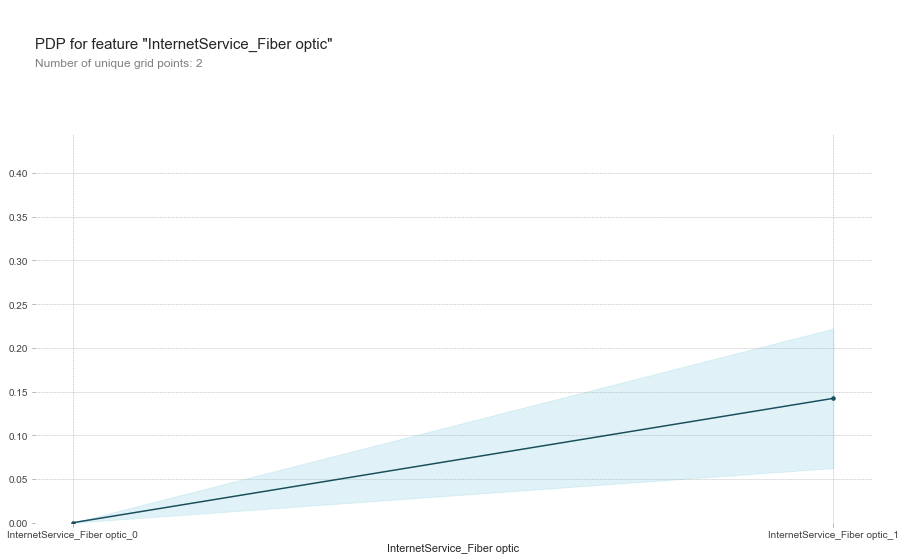

In [40]:
pdp_p = pdp.pdp_isolate(model=model, dataset=X_test, model_features=X_test.columns.values, 
                        feature='InternetService_Fiber optic')
pdp.pdp_plot(pdp_p, 'InternetService_Fiber optic')
plt.show()

#### Monthly Charges

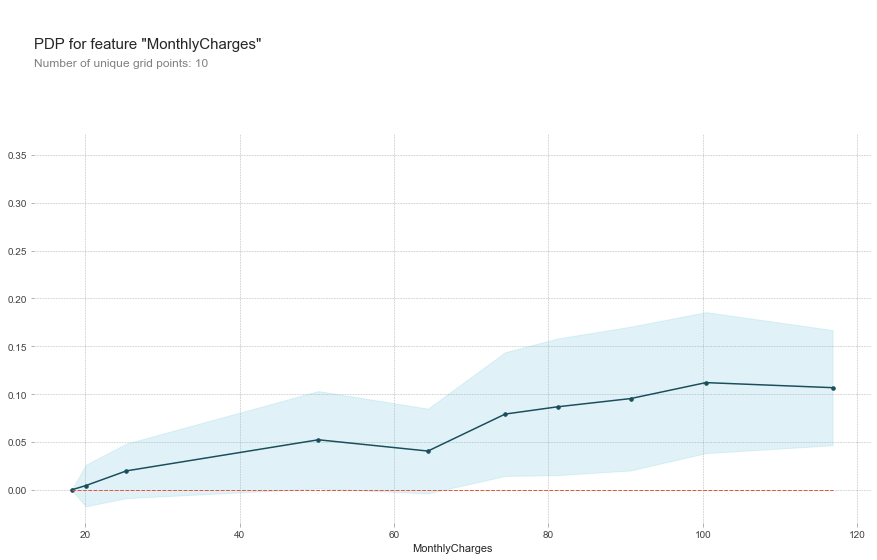

In [41]:
pdp_p = pdp.pdp_isolate(model=model, dataset=X_test, model_features=X_test.columns, feature='MonthlyCharges')
pdp.pdp_plot(pdp_p, 'MonthlyCharges')
plt.show()

#### Total Charges

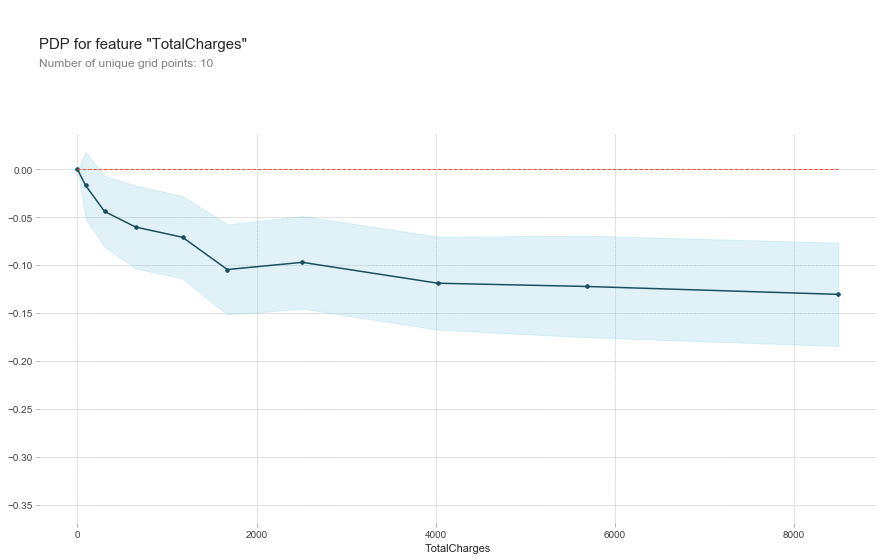

In [42]:
pdp_p = pdp.pdp_isolate(model=model, dataset=X_test, model_features=X_test.columns.values, feature='TotalCharges')
pdp.pdp_plot(pdp_p, 'TotalCharges')
plt.show()

#### Payment Method: Mailed Check

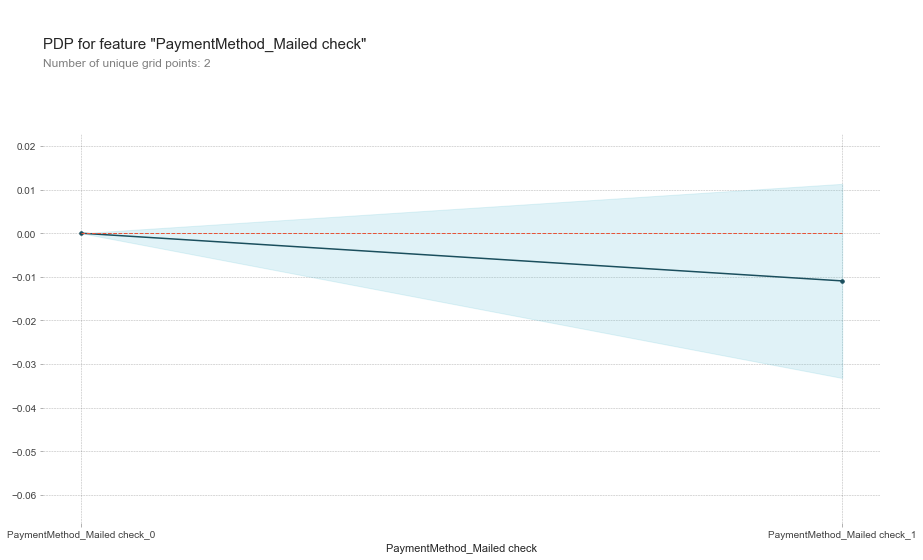

In [43]:
pdp_p = pdp.pdp_isolate(model=model, dataset=X_test, model_features=X_test.columns.values, 
                        feature='PaymentMethod_Mailed check')
pdp.pdp_plot(pdp_p, 'PaymentMethod_Mailed check')
plt.show()

#### Contract - Two years

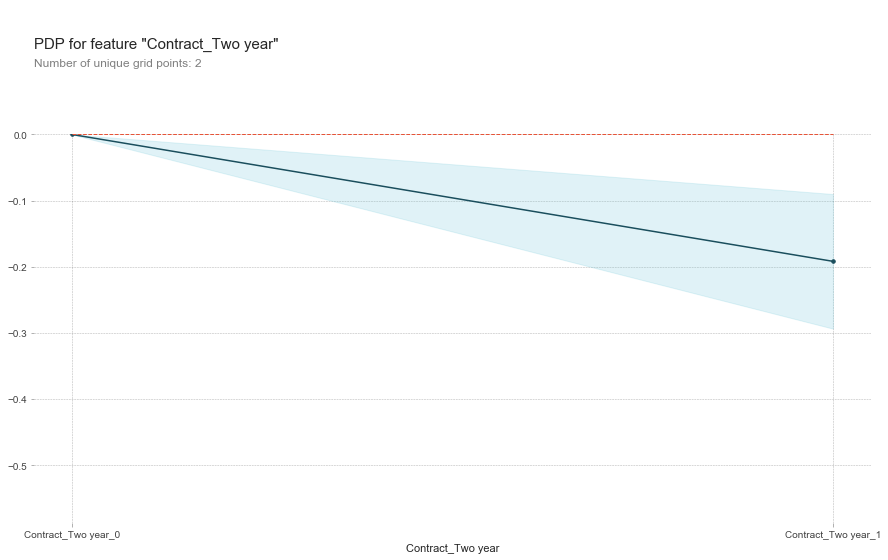

In [44]:
pdp_p = pdp.pdp_isolate(model=model, dataset=X_test, model_features=X_test.columns.values, 
                        feature='Contract_Two year')
pdp.pdp_plot(pdp_p, 'Contract_Two year')
plt.show()

### Shap Values

In [45]:
import shap 
shap.initjs()

import joblib

In [46]:
explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values((X_test.iloc[0]))
shap.force_plot(explainer.expected_value[1], shap_values[1], X_test.iloc[0])

In [47]:
# Saving Explainer
ex_filename = 'explainer.bz2'
joblib.dump(explainer, filename=ex_filename, compress=('bz2', 9))

['explainer.bz2']

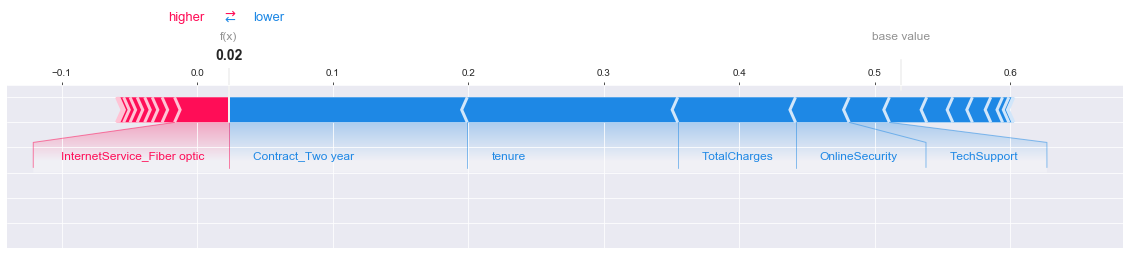

In [49]:
explainer = joblib.load(filename="explainer.bz2")
shap_values = explainer.shap_values(np.array(X_test.iloc[0]))
shap.force_plot(explainer.expected_value[1], shap_values[1], list(X_test.columns), matplotlib = True, show = False).savefig('shap.png', bbox_inches="tight")    

### Summary Plot

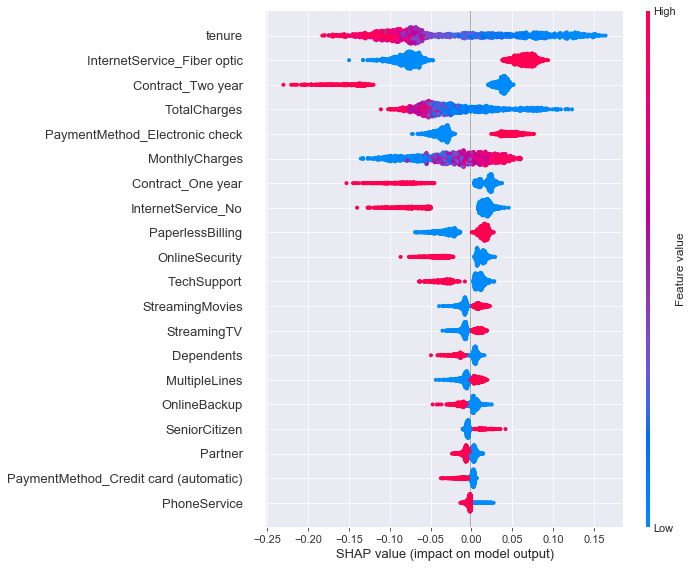

In [50]:
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[1], X_test)

### Gauge Chart 

In [51]:
from matplotlib.patches import Circle, Wedge, Rectangle

def degree_range(n): 
    start = np.linspace(0,180,n+1, endpoint=True)[0:-1]
    end = np.linspace(0,180,n+1, endpoint=True)[1::]
    mid_points = start + ((end-start)/2.)
    return np.c_[start, end], mid_points

def rot_text(ang): 
    rotation = np.degrees(np.radians(ang) * np.pi / np.pi - np.radians(90))
    return rotation

def gauge(labels=['LOW','MEDIUM','HIGH','EXTREME'], \
          colors=['#007A00','#0063BF','#FFCC00','#ED1C24'], Probability=1, fname=False): 
    
    N = len(labels)
    colors = colors[::-1]

    """
    begins the plotting
    """
    
    fig, ax = plt.subplots()

    ang_range, mid_points = degree_range(4)

    labels = labels[::-1]
    
    """
    plots the sectors and the arcs
    """
    patches = []
    for ang, c in zip(ang_range, colors): 
        # sectors
        patches.append(Wedge((0.,0.), .4, *ang, facecolor='w', lw=2))
        # arcs
        patches.append(Wedge((0.,0.), .4, *ang, width=0.10, facecolor=c, lw=2, alpha=0.5))
    
    [ax.add_patch(p) for p in patches]

    
    """
    set the labels (e.g. 'LOW','MEDIUM',...)
    """

    for mid, lab in zip(mid_points, labels): 

        ax.text(0.35 * np.cos(np.radians(mid)), 0.35 * np.sin(np.radians(mid)), lab, \
            horizontalalignment='center', verticalalignment='center', fontsize=14, \
            fontweight='bold', rotation = rot_text(mid))

    """
    set the bottom banner and the title
    """
    r = Rectangle((-0.4,-0.1),0.8,0.1, facecolor='w', lw=2)
    ax.add_patch(r)
    
    ax.text(0, -0.05, 'Churn Probability ' + np.round(Probability,2).astype(str), horizontalalignment='center', \
         verticalalignment='center', fontsize=22, fontweight='bold')

    """
    plots the arrow now
    """
    
    pos = (1-Probability)*180
    ax.arrow(0, 0, 0.225 * np.cos(np.radians(pos)), 0.225 * np.sin(np.radians(pos)), \
                 width=0.04, head_width=0.09, head_length=0.1, fc='k', ec='k')
    
    ax.add_patch(Circle((0, 0), radius=0.02, facecolor='k'))
    ax.add_patch(Circle((0, 0), radius=0.01, facecolor='w', zorder=11))

    """
    removes frame and ticks, and makes axis equal and tight
    """
    
    ax.set_frame_on(False)
    ax.axes.set_xticks([])
    ax.axes.set_yticks([])
    ax.axis('equal')
    plt.tight_layout()
    if fname:
        fig.savefig(fname, dpi=200)

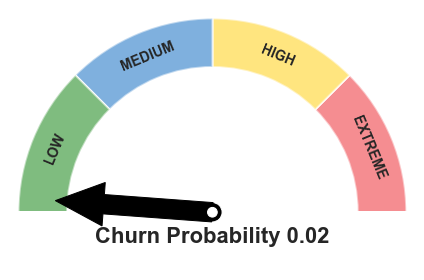

In [52]:
gauge(Probability=model.predict_proba(X_test.iloc[0:1])[0,1])

Final Features

In [53]:
X_test.iloc[0:1]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
437,0,0,1,1,72,1,1,1,1,1,1,1,1,1,114.05,8468.2,1,0,0,1,1,0,0
